In [1]:
import rasterio
import geopandas as gpd
from dotenv import load_dotenv
import os
import xarray as xr
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterstats
import scipy
import pandas as pd
import tempfile
import shutil
from tqdm import tqdm

load_dotenv()
directory = os.getenv("path")
climate_path = os.getenv("climate_path")

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.resetwarnings()

In [21]:
def plot_raster_and_shapefile(raster_path, shapefile_path):
    # raster
    rf = rasterio.open(raster_path)

    # shapefile
    shp = gpd.read_file(shapefile_path)

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    show(rf, ax=ax, title='on polygons')
    shp.plot(ax=ax, facecolor = None, edgecolor='yellow')

    return plt.show()

Working solution

In [ ]:
output_path = os.getenv("output_path")
def climate_indices_stats(reference_dataset_path, climate_indices_path, shapefile_path) -> dict:
    # reference dataset
    ds = xr.open_dataset(reference_dataset_path)

    # shapefile
    shp = gpd.read_file(shapefile_path)

    # climate indices data initially stored in a matlab files
    mat_data = scipy.io.loadmat(climate_indices_path)
    climate_indices = [key for key in mat_data.keys() if '__' not in key]

    zonal_climate_stats = {}

    # loop through the climate indices
    for index in climate_indices:
        mat_shape = mat_data[index].shape
        if mat_shape[0] == 630:
            ds[index] = (('y', 'x'), mat_data[index].T)
        else:
            ds[index] = (('y', 'x'), mat_data[index].T)

        # replace the climate indices with the reference dataset
        try:
            new_netcdf = xr.DataArray(
                data=ds[index],
                dims=("y", "x"),
                coords={"y": ds.y, "x": ds.x},
            )
            ds['prcp'] = new_netcdf

            # add crs to the raster
            ds.rio.write_crs(shp.crs, inplace=True)

            temp_dir = tempfile.mkdtemp(dir=output_path)
            rf_path = os.path.join(temp_dir, f"{index}.tif")
            ds.prcp.rio.to_raster(rf_path)

            # zonal stats
            stats = rasterstats.zonal_stats(shp, rf_path, stats="mean")
            zonal_climate_stats[index] = stats

        finally:
            shutil.rmtree(temp_dir)

    return zonal_climate_stats

In [ ]:
def climate_zonal_datasets(shp_path_on, shp_path_us, reference_dataset_path, dir_climate_indices) -> pd.DataFrame:

    climate_indices_paths = os.listdir(dir_climate_indices)

    year_indices = {}

    for file in tqdm(climate_indices_paths):
        year_matrix = int(file.split("_")[1].split("r")[1])
        dir_file = os.path.join(directory, "ClimateIndices", "indices", file)
        on_stats = climate_indices_stats(reference_dataset_path, dir_file, shp_path_on)
        us_stats = climate_indices_stats(reference_dataset_path, dir_file, shp_path_us)

        year_indices[year_matrix] = [on_stats, us_stats]

    return year_indices

In [24]:
# -- solution
dir_climate_indices = os.path.join(directory, "ClimateIndices", "indices")
reference_dataset_path = os.path.join(directory, "ClimateIndices", "original_dataset.nc")
us_polygons = os.path.join(directory, "ClimateIndices", "georeference", "us_subbasins")
on_polygons= os.path.join(directory, "ClimateIndices", "georeference", "on_subbasins", "new_ON_subbasins.shp")

zonal_results = climate_zonal_datasets(on_polygons, us_polygons, reference_dataset_path, dir_climate_indices)

on_subbasins = list(gpd.read_file(on_polygons)['Station'])
us_subbasins = list(gpd.read_file(us_polygons)['GAGE_ID'])
basins = on_subbasins + us_subbasins

for y in tqdm(zonal_results):
    all_indices_yr = []
    for index in zonal_results[y][0]:
        if index in zonal_results[y][1]:
            countries_combined_stats = zonal_results[y][0][index] + zonal_results[y][1][index]
            df = pd.DataFrame(countries_combined_stats)
            df.columns = [f"{index.split('_mapcurrentyear')[0]}_{y}"]
            all_indices_yr.append(df)

    all_indices_yr_df = pd.concat(all_indices_yr, axis=1)
    all_indices_yr_df.index = basins
    all_indices_yr_df.to_csv(os.path.join(climate_path, f"climate_indices_{y}.csv"))

In [ ]:
import os
import geopandas as gpd
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from matplotlib.colors import Normalize
from matplotlib import cm

# Define file paths
_2015_dir_climate_indices = os.path.join(directory, "raw_data", "climate_data", "indices", "ClimateIndices_Year2015_GeneratedNov2023.mat")
leb_boundary_path = os.path.join(directory, "LEB_description", "sub-basin _ArcGIS", "LakeErieBasinBoundaries.shp")

# Load the boundary shapefile and convert to CRS EPSG:4326
boundary = gpd.read_file(leb_boundary_path)
boundary = boundary

# Load the .mat file and extract the relevant data
mat_data = scipy.io.loadmat(_2015_dir_climate_indices)
data = mat_data['AnnualTotalPrcp_mapcurrentyear']

# Define the data extent based on the known bounds
minx, miny, maxx, maxy = boundary.total_bounds

# Create a mask for the raster data using the boundary polygon
ny, nx = data.shape
x = np.linspace(minx, maxx, nx)
y = np.linspace(miny, maxy, ny)[::-1]  # Reverse the y-axis data
xv, yv = np.meshgrid(x, y)

# Create a GeoDataFrame from the raster coordinates
coords = np.dstack([xv, yv]).reshape(-1, 2)
gdf_raster = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coords[:, 0], coords[:, 1]), crs=boundary.crs)

# Clip raster data points using the boundary
mask = gdf_raster.within(boundary.unary_union)

# Reshape the mask to the raster shape
clipped_data = np.where(mask.values.reshape(ny, nx), data, np.nan)

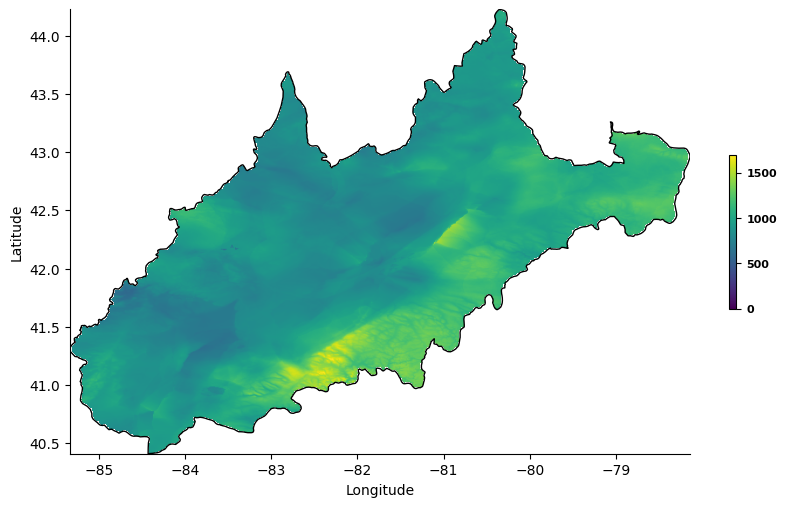

In [44]:
from matplotlib import font_manager

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the clipped data
cax = ax.imshow(clipped_data, extent=[minx, maxx, miny, maxy], cmap='viridis', norm=Normalize(vmin=0, vmax=np.nanmax(clipped_data)))

# Overlay the polygon boundary
boundary.plot(ax=ax, facecolor='none', edgecolor='black')

bold_font = font_manager.FontProperties(weight='bold')

cbar = plt.colorbar(cax, shrink=0.2) 

for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(bold_font)
    label.set_fontsize(8)
# Remove the square borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set plot title and labels
# ax.set_title('Annual Total Precipitation with Lake Erie Basin Boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()